# Trabajo Práctico Nro. 1B 
### Ing. Javier Ouret - 2025 - UCA - Facultad de Ingeniería
## Ejemplos de Raw Sockets usando bash kernel para su compilación.

### ¿Qué es un Raw Socket?

Es un tipo especial de socket que permite enviar y recibir paquetes sin procesar a nivel de red, saltándose las abstracciones del sistema operativo.   
Se pueden crear paquetes IP, TCP, UDP o ICMP personalizados.   
Para qué se usan:
- Construcción de herramientas de red (ping, traceroute, nmap).
- Implementación de protocolos personalizados.
- Monitoreo y análisis de tráfico.
- Pruebas de seguridad (ethical hacking).

| Característica         | Detalle                                                  |
| ---------------------- | -------------------------------------------------------- |
| Nivel de operación     | Capa de red (OSI capa 3) o superior (capa 4).            |
| Permisos necesarios    | Root (por razones de seguridad).                         |
| Encabezado | IP, TCP, UDP, ICMP. |
| OS          | Linux y BSD (limitado en Windows).                       |


#### Creación de Raw Sockets en C

Para poder ver protocolo IP sin procesar ETH_P_IP = 0x0800, uprotocolo para paquetes IP (IPv4).

**IMPORTANTE: para usar raw sockets se necesitan privilegios de superusuario (root), ya que puede
generar tráfico malicioso.**
Raw sockets permiten falsificación de IP, sniffing, y otros ataques. 
- Algunos sistemas limitan su uso.
- Usarlos sólo en entornos controlados y con fines educativos o de prueba.

#### Control del Encabezado IP

#### Estructura de un Paquete IP Personalizado

### A) Ping Básico. Usa ICMP Echo Request.

#### Estructura del paquete ICMP (Echo Request)

#### Estructura del header IP:

#### Estructura del header ICMP:

#### Cálculo del checksum en Python (igual que en C)

#### Código en C para enviar un paquete ICMP

In [1]:
echo '#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <sys/socket.h>
#include <arpa/inet.h>
#include <netinet/ip.h>
#include <netinet/ip_icmp.h>
#include <unistd.h>
#include <errno.h>
#include <sys/time.h>

#define PACKET_SIZE 4096
#define DEST_IP "127.0.0.1"
#define MAX_PINGS 5

unsigned short checksum(void *b, int len) {
    unsigned short *buf = b;
    unsigned int sum = 0;
    for (; len > 1; len -= 2)
        sum += *buf++;
    if (len == 1)
        sum += *(unsigned char*)buf;
    sum = (sum >> 16) + (sum & 0xFFFF);
    sum += (sum >> 16);
    return ~sum;
}

int main() {
    char packet[PACKET_SIZE];
    struct sockaddr_in dest;
    int sockfd, one = 1;
    struct timeval timeout = {1, 0};  // 1 segundo de timeout

    sockfd = socket(AF_INET, SOCK_RAW, IPPROTO_ICMP);
    if (sockfd < 0) {
        perror("socket");
        return 1;
    }

    // Permite incluir cabecera IP
    setsockopt(sockfd, IPPROTO_IP, IP_HDRINCL, &one, sizeof(one));
    // Configura timeout de recepción
    setsockopt(sockfd, SOL_SOCKET, SO_RCVTIMEO, &timeout, sizeof(timeout));

    dest.sin_family = AF_INET;
    dest.sin_addr.s_addr = inet_addr(DEST_IP);

    for (int seq = 1; seq <= MAX_PINGS; seq++) {
        memset(packet, 0, PACKET_SIZE);

        struct iphdr *ip = (struct iphdr *) packet;
        struct icmphdr *icmp = (struct icmphdr *) (packet + sizeof(struct iphdr));

        // IP Header
        ip->ihl = 5;
        ip->version = 4;
        ip->tos = 0;
        ip->tot_len = htons(sizeof(struct iphdr) + sizeof(struct icmphdr));
        ip->id = htons(1234 + seq);
        ip->frag_off = 0;
        ip->ttl = 64;
        ip->protocol = IPPROTO_ICMP;
        ip->saddr = inet_addr("127.0.0.1");  // IP local para pruebas
        ip->daddr = dest.sin_addr.s_addr;
        ip->check = checksum((unsigned short *)ip, sizeof(struct iphdr));

        // ICMP Header
        icmp->type = ICMP_ECHO;
        icmp->code = 0;
        icmp->un.echo.id = htons(1234);
        icmp->un.echo.sequence = htons(seq);
        icmp->checksum = checksum((unsigned short *)icmp, sizeof(struct icmphdr));

        if (sendto(sockfd, packet, ntohs(ip->tot_len), 0,
                   (struct sockaddr *)&dest, sizeof(dest)) < 0) {
            perror("sendto");
        } else {
            printf("Ping #%d enviado a %s...\n", seq, DEST_IP);
        }

        // Recibir respuesta
        char recv_buffer[PACKET_SIZE];
        struct sockaddr_in recv_addr;
        socklen_t addr_len = sizeof(recv_addr);

        ssize_t bytes = recvfrom(sockfd, recv_buffer, sizeof(recv_buffer), 0,
                                 (struct sockaddr *)&recv_addr, &addr_len);

        if (bytes < 0) {
            if (errno == EAGAIN || errno == EWOULDBLOCK)
                printf("Timeout esperando respuesta ICMP #%d\n", seq);
            else
                perror("recvfrom");
        } else {
            struct iphdr *recv_ip = (struct iphdr *)recv_buffer;
            struct icmphdr *recv_icmp = (struct icmphdr *)(recv_buffer + (recv_ip->ihl * 4));

            if (recv_icmp->type == ICMP_ECHOREPLY) {
                printf("Respuesta ICMP #%d recibida desde %s\n\n",
                       ntohs(recv_icmp->un.echo.sequence),
                       inet_ntoa(recv_addr.sin_addr));
            } else {
                printf("Recibido otro tipo de paquete ICMP: tipo %d\n", recv_icmp->type);
            }
        }

        sleep(1);  // esperar 1 segundo antes del próximo ping
    }

    close(sockfd);
    return 0;
}' > raw_sockets_ping.c

**NOTA: Cerrar las ventanas de las Terminales al finalizar su uso**

Compilo el código usando Bash C:

In [4]:
gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
gcc raw_sockets_ping.c -o raw_sockets_ping

Verifico que el ejecutable esté disponible:

In [6]:
ls

'020111417FN-Espacio para entregas TP1 - 2025-1862142'
'020111417FN-Espacio para entregas TP1 - 2025-1862142.zip'
 16
 cliente
 cliente.c
 cliente_no_bloqueante2
 cliente_no_bloqueante2.c
 cliente_no_bloqueante_iterativo_TCP
 cliente_no_bloqueante_iterativo_TCP.c
 cliente_no_bloqueante_iterativo_UDP
 cliente_no_bloqueante_iterativo_UDP.c
 Cliente_Servidor_No_Bloqueante_C_R1.ipynb
'Cliente Servidor TCP con bash.ipynb'
 cliente_tcp_bash
 cliente_tcp_bash.c
 cliente_tcp_c.ipynb
 crear_estructura_udp_web.sh
 icmp_packet.bin
 Ping_raw_sockets.c
 Proceso_01_Serial.py
 Proceso_02_Concurrente.py
 proyecto_udp_web
'prueba de C con bash.ipynb'
 raw_sockets_ping
 raw_sockets_ping.c
 raw_sockets_sniffer
 raw_sockets_sniffer.c
 raw_sockets_tcp.c
 servidor
 servidor.c
 servidor_no_bloqueante2
 servidor_no_bloqueante2.c
 servidor_no_bloqueante_iterativo_TCP
 servidor_no_bloqueante_iterativo_TCP.c
 servidor_no_bloqueante_iterativo_UDP
 servidor_no_bloqueante_iterativo_UDP.c
 servidor_tcp_bash
 servido

La terminal de Jupyter puede funcionar mal. Para ejecutarlo correctamente abro ventana por afuera del Jupyter Notebook:

In [11]:
gnome-terminal -- bash -c "sudo ./raw_sockets_ping"

Capturarlo con tcpdump en la interfaz lo

In [ ]:
gnome-terminal -- bash -c "sudo tcpdump -i lo -nv icmp"

#### Visualizar el paquete en Python

In [ ]:
import binascii

# Supongamos que el paquete ya fue capturado en formato binario
packet = b'\x45\x00\x00\x1c\x30\x39\x00\x00\x40\x01\xa6\xec\xc0\xa8\x00\x64\x08\x08\x08\x08\x08\x00\xf7\xff\x04\xd2\x00\x01'

# Mostrar byte a byte
print("Paquete (hex):")
for i in range(0, len(packet), 2):
    print(binascii.hexlify(packet[i:i+2]), end=' ')


### B) Sniffer ICMP.

Este programa crea un socket RAW para recibir todos los paquetes IP y filtra los ICMP. 
- Se guarda el contenido del paquete en un archivo binario para luego analizarlo con Python.

In [7]:
echo '#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>
#include <sys/socket.h>
#include <arpa/inet.h>
#include <netinet/ip.h>
#include <netinet/ip_icmp.h>

int main() {
    int sockfd;
    char buffer[65536];
    struct sockaddr saddr;
    socklen_t saddr_len = sizeof(saddr);

    // Crear raw socket
    sockfd = socket(AF_INET, SOCK_RAW, IPPROTO_ICMP);
    if (sockfd < 0) {
        perror("Socket error");
        return 1;
    }

    printf("Sniffer ICMP iniciado... (Ctrl+C para detener)\n");

    while (1) {
        ssize_t packet_size = recvfrom(sockfd, buffer, sizeof(buffer), 0, &saddr, &saddr_len);
        if (packet_size < 0) {
            perror("recvfrom error");
            continue;
        }

        struct iphdr *ip = (struct iphdr*) buffer;
        if (ip->protocol == IPPROTO_ICMP) {
            struct icmphdr *icmp = (struct icmphdr*)(buffer + ip->ihl * 4);
            printf("ICMP capturado: Tipo=%d Código=%d ID=%d Secuencia=%d\n",
                icmp->type,
                icmp->code,
                ntohs(icmp->un.echo.id),
                ntohs(icmp->un.echo.sequence)
            );

            // Guardar en archivo para analizar con Python
            FILE *f = fopen("icmp_packet.bin", "wb");
            if (f) {
                fwrite(buffer, 1, packet_size, f);
                fclose(f);
                printf("Paquete guardado en icmp_packet.bin\n");
                break; // solo capturamos uno para el ejemplo
            }
        }
    }

    close(sockfd);
    return 0;
}' > raw_sockets_sniffer.c

Compilo el código usando Bash C:

In [8]:
gcc raw_sockets_sniffer.c -o raw_sockets_sniffer

In [ ]:
gnome-terminal -- bash -c "sudo ./raw_sockets_sniffer"

#### Ejecutar ping 127.0.0.1 o la IP local o remota desde otra terminal para generar tráfico ICMP.

#### Leer y visualizar el paquete en Python

In [1]:
import struct
import binascii

with open("icmp_packet.bin", "rb") as f:
    data = f.read()

print("Paquete capturado:")
print(binascii.hexlify(data, sep=' '))

# Extraer y mostrar cabeceras IP e ICMP
ip_header = data[:20]
ip_fields = struct.unpack("!BBHHHBBH4s4s", ip_header)

print("\n IP Header:")
print(f"Version: {ip_fields[0] >> 4}")
print(f"IHL: {ip_fields[0] & 0xF} ({(ip_fields[0] & 0xF)*4} bytes)")
print(f"Total Length: {ip_fields[2]}")
print(f"Protocol: {ip_fields[6]} (should be 1 for ICMP)")
print(f"Source IP: {'.'.join(map(str, ip_fields[8]))}")
print(f"Destination IP: {'.'.join(map(str, ip_fields[9]))}")

icmp_offset = (ip_fields[0] & 0xF) * 4
icmp_header = data[icmp_offset:icmp_offset+8]
icmp_fields = struct.unpack("!BBHHH", icmp_header)

print("\nICMP Header:")
print(f"Type: {icmp_fields[0]}")
print(f"Code: {icmp_fields[1]}")
print(f"Checksum: {hex(icmp_fields[2])}")
print(f"ID: {icmp_fields[3]}")
print(f"Sequence: {icmp_fields[4]}")

Paquete capturado:
b'45 00 00 1c 04 d3 00 00 40 01 78 0c 7f 00 00 01 7f 00 00 01 08 00 f3 2c 04 d2 00 01'

 IP Header:
Version: 4
IHL: 5 (20 bytes)
Total Length: 28
Protocol: 1 (should be 1 for ICMP)
Source IP: 127.0.0.1
Destination IP: 127.0.0.1

ICMP Header:
Type: 8
Code: 0
Checksum: 0xf32c
ID: 1234
Sequence: 1


Ejemplo de captura:

Visualización gráfica del paquete binario con matplotlib.   
Se muestra:
- Los bytes como valores hexadecimales.
- Un mapa de calor (heatmap) donde cada byte es un píxel codificado por color.


**Instalar matplotlib**

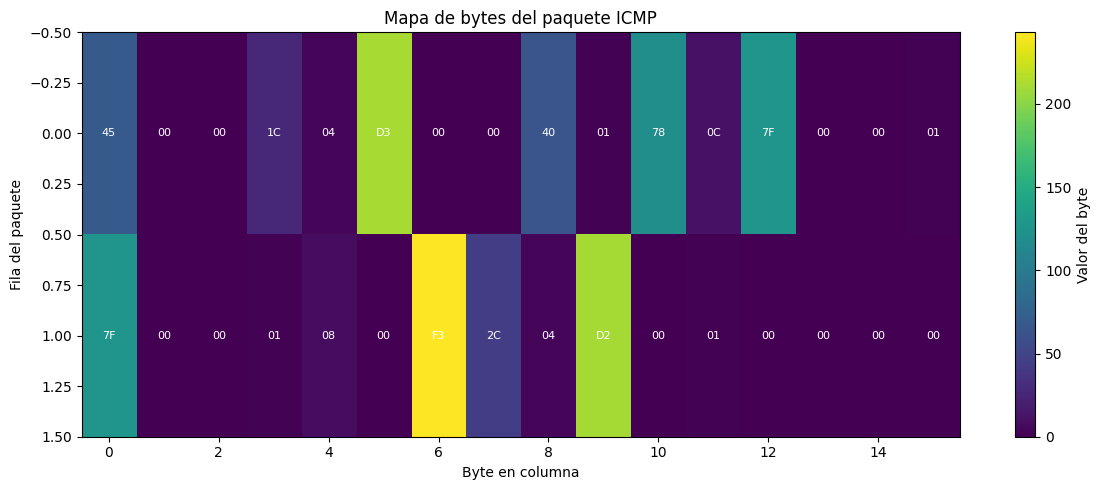

In [2]:
# visualizar_paquete.py
import matplotlib.pyplot as plt
import numpy as np

# Leer el paquete
with open("icmp_packet.bin", "rb") as f:
    packet = f.read()

# Convertir a matriz de bytes
bytes_list = list(packet)
length = len(bytes_list)
cols = 16
rows = (length + cols - 1) // cols

# Rellenar con ceros si no es múltiplo de 16
padded = bytes_list + [0] * (rows * cols - length)
matrix = np.array(padded).reshape((rows, cols))

# Visualización
plt.figure(figsize=(12, 5))
plt.imshow(matrix, cmap='viridis', aspect='auto')
plt.title("Mapa de bytes del paquete ICMP")
plt.colorbar(label="Valor del byte")
plt.xlabel("Byte en columna")
plt.ylabel("Fila del paquete")

# Mostrar valores hex en la matriz
for i in range(rows):
    for j in range(cols):
        byte_val = matrix[i, j]
        plt.text(j, i, f'{byte_val:02X}', ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()


### Enviar paquete TCP SYN con Raw Socket en C

In [1]:
cat << 'EOF' > raw_sockets_tcp.c
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <unistd.h>
#include <arpa/inet.h>
#include <sys/socket.h>
#include <netinet/ip.h>
#include <netinet/tcp.h>

// Calcula checksum para IP/TCP
unsigned short checksum(unsigned short *ptr, int nbytes) {
    long sum = 0;
    unsigned short oddbyte;
    unsigned short answer;

    while(nbytes > 1) {
        sum += *ptr++;
        nbytes -= 2;
    }

    if(nbytes == 1) {
        oddbyte = 0;
        *((unsigned char*)&oddbyte) = *(unsigned char*)ptr;
        sum += oddbyte;
    }

    sum = (sum >> 16) + (sum & 0xffff);
    sum += (sum >> 16);
    answer = ~sum;

    return answer;
}

// Cabecera pseudo para el checksum TCP
struct pseudo_header {
    unsigned int source_address;
    unsigned int dest_address;
    unsigned char placeholder;
    unsigned char protocol;
    unsigned short tcp_length;
};

int main() {
    // Crear socket raw
    int sock = socket(AF_INET, SOCK_RAW, IPPROTO_TCP);
    if(sock < 0) {
        perror("socket error");
        return 1;
    }

    // Datos del paquete
    char datagram[4096], *data, *pseudogram;
    memset(datagram, 0, 4096);

    // Cabeceras IP y TCP
    struct iphdr *iph = (struct iphdr *)datagram;
    struct tcphdr *tcph = (struct tcphdr *)(datagram + sizeof(struct iphdr));

    struct sockaddr_in sin;
    sin.sin_family = AF_INET;
    sin.sin_port = htons(80);  // Puerto destino
    sin.sin_addr.s_addr = inet_addr("127.0.0.1");  // Cambiar por destino real

    // Datos a enviar (puede ser vacío en SYN)
    data = datagram + sizeof(struct iphdr) + sizeof(struct tcphdr);
    strcpy(data, "");  // datos opcionales

    // Rellenar cabecera IP
    iph->ihl = 5;
    iph->version = 4;
    iph->tos = 0;
    iph->tot_len = sizeof(struct iphdr) + sizeof(struct tcphdr);
    iph->id = htons(54321);
    iph->frag_off = 0;
    iph->ttl = 64;
    iph->protocol = IPPROTO_TCP;
    iph->saddr = inet_addr("127.0.0.1"); // Cambiar a IP local
    iph->daddr = sin.sin_addr.s_addr;
    iph->check = checksum((unsigned short *)datagram, iph->tot_len);

    // Cabecera TCP
    tcph->source = htons(1234);
    tcph->dest = htons(80);
    tcph->seq = htonl(0);
    tcph->ack_seq = 0;
    tcph->doff = 5;
    tcph->syn = 1;
    tcph->window = htons(5840);
    tcph->check = 0;
    tcph->urg_ptr = 0;

    // Cabecera pseudo para checksum TCP
    struct pseudo_header psh;
    psh.source_address = iph->saddr;
    psh.dest_address = iph->daddr;
    psh.placeholder = 0;
    psh.protocol = IPPROTO_TCP;
    psh.tcp_length = htons(sizeof(struct tcphdr));

    int psize = sizeof(struct pseudo_header) + sizeof(struct tcphdr);
    pseudogram = malloc(psize);

    memcpy(pseudogram, &psh, sizeof(struct pseudo_header));
    memcpy(pseudogram + sizeof(struct pseudo_header), tcph, sizeof(struct tcphdr));

    tcph->check = checksum((unsigned short *)pseudogram, psize);

    // Permitir incluir cabecera IP
    int one = 1;
    if (setsockopt(sock, IPPROTO_IP, IP_HDRINCL, &one, sizeof(one)) < 0) {
        perror("setsockopt error");
        return 1;
    }

    // Enviar paquete
    if (sendto(sock, datagram, iph->tot_len, 0,
               (struct sockaddr *)&sin, sizeof(sin)) < 0) {
        perror("sendto failed");
    } else {
        printf("Paquete TCP SYN enviado a %s\n", inet_ntoa(sin.sin_addr));
    }

    free(pseudogram);
    close(sock);
    return 0;
}
EOF

### Consigna del TP 1B
**Ejercicios a realizar durante la clase. Incluir los códigos dentro de este mismo Notebook**

Con esta información es posible crear un simple "sniffer", que muestre todo el contenido de los paquetes TCP que se reciban. ( En este ejemplo se evitan los headers IP y TCP, y se imprime solamente el "payload" con encabezados IP y TCP contenidos en el paquete ).
Usar también tcpdump que es una herramienta de línea de comandos en sistemas Unix/Linux que sirve para capturar y analizar tráfico de red. Funciona a nivel de capa de enlace (nivel 2 del modelo OSI) y utiliza libpcap para interceptar paquetes.

- Utilizando el código "sniffer" que es un programa que muestra el contenido del tráfico que llega, modificarlo para explicar cada paso que va ejecutando en pantalla.
- Modificar el sniffer para que vaya mostrando todo el tráfico que llega.
- Enviar tráfico al "sniffer" desde el cliente escrito en la parte A del TP1
- Enviar tráfico ICMP al "sniffer" y mostrar los resultados con un LOG con comentarios.
- Explicar las estructuras del código de ICMP y del Sniffer, especialmente los campos de protocolo.
- Estudiar el "sniffer" para que muestre IP, TCP y UDP.
- Mostrar resultados.


#### Para raw_sockets_tcp.c
- El programa anterior arma paquete IP + TCP.
- Lo envía como un SYN (inicio de conexión TCP).
- Calcula los checksums (IP y TCP).
- Requiere IP de origen válida.
- Probar con IPs distintas de localhost
- Verlo con tcpdump
- Mientras se ejecuta el programa, en otra terminal ejecutar tcpdump (reemplazar por interfaz correcta si es necesario)

sudo tcpdump -i lo or -i wlp1s0 tcp